# Determinación de los parámetros de anisotropía magnetocristalina y uniaxial
Se usarán las mediciones de magnetoresistencia anisotrópica para ajustar los parámetros del modelo teórico.<br>

## Método 1
Para poder calcular los parámetros $K_u$ y $K_c$, calculamos los valores de $\cos^2\psi$ y $\cos\psi\sin\psi$ con respecto al campo magnético externo y lo ajustamos al los datos calculados.<br>

$$F(\psi) =-M H\cos(\psi - \phi_H) - \frac{K_c}{4}  \sin^2(2\psi) - K_u\cos^2(\psi - \phi_u)$$

Para simplificar la expresión asumiremos que $\phi_H=0$ (por la forma en la que se realizó el experimento) y que $\phi_u=0$(la corriente fluye a lo largo del eje fácil). Ahora, si derivamos la función con respecto a  $\psi$ obtenemos:
$$F'(\psi)=MH\sin(\psi) -\frac{K_c}{4}\sin(4\psi)+K_u\cos(2\psi) $$

Sea $H_{ext,i} $ un campo magnético externo y $\psi_i$ su ángulo con la magnetización que minimiza la energía libre, entonces:
$$MH_{ext,i}\sin(\psi_i)-\frac{K_c}{4}\sin(4\psi_i)+K_u\sin(2\psi_i)=0$$
Dividiendo entre $K_u$:
$$H_{ext,i}\sin(\psi_i)-\frac{R_c}{4}\sin(4\psi_i)+R_u\sin(2\psi_i)=0$$
donde $R_u=K_u/M$  y $R_c=K_c/M$ son los parámetros a ajustar, de esta manera podemos obtener los parámetros.
Usando las medidas para $\rho_xy $ vs H y normalizando esta función para obtener $\cos^2\psi$ vs H. Despejamos H de la ecuación anterior:
$$
H_{ext,i}=\frac{\dfrac{R_c}{4}\sin(4\psi_i)-R_u\sin(2\psi_i)}{\sin\psi_i}
$$
Asumiendo que $R_u$=0
$$
R_c=\frac{4H_{ext,i}sin(\psi)}{sin(4\psi)}
$$

In [1]:

from scipy.optimize import  minimize,root
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd

# Definir H_ext como función a ajustar
def H_ext(vars, R_c, R_u):
    psi, phi_H = vars  # Descomponer las variables independientes
    psi = np.radians(psi)  
    phi_M = np.radians(phi_M)
    return (R_c/4 * np.sin(4*psi) - R_u * np.sin(2*psi)) / (np.sin(psi - phi_H))
def is_numeric(value):
    return pd.to_numeric(value, errors='coerce')
def rxx_func(psi, r_p, dr):
        psi=np.radians(psi)
        return r_p + dr * np.cos(psi)**2
def parametros(temp):
    path = "K_300mT_angular.txt"
    base_dir = "Datos/RvsH_angle_vsT_SECTOR1/"
    archivo = base_dir + str(temp) + path
    df = pd.read_csv(archivo, encoding="latin-1")
    df_numeric = df.map(is_numeric)
    df = df_numeric.dropna()
    Rxx=df["Rxx (ohm)"].to_numpy()
    angle=df["angle (°)"]
    initial_guess=[1,1]
    params,_=curve_fit(rxx_func,angle,Rxx,p0=initial_guess)
    r_perp,dr=params
    return r_perp,dr
# Función para cargar los datos y realizar el ajuste
def ajustar_H_ext(psi, campo, phi_M):
    # Ajustar H_ext a los datos experimentales
    initial_guess = [145, 25]  # Valores iniciales de R_c y R_u
    params, _ = curve_fit(H_ext, (psi, phi_M), campo, p0=initial_guess)
    R_c, R_u = params
    return R_c, R_u

# Cargar los datos de psi y campo magnético
def cargar_datos(temp):
    path = "K.txt"
    base_dir = "Datos/RvsHvsT_SECTOR2/EA/"
    archivo = base_dir + str(temp) + path
    df = pd.read_csv(archivo, encoding="latin-1")
    # print(df.columns)
    r_perp, dr = parametros(temp)  # Obtener r_perp y dr usando la función anterior
    Rxx = df["Rxx (ohm)"]
    cos_psi_2 = (Rxx - r_perp) / dr
    x = cos_psi_2 - (max(cos_psi_2) - 1)
    psi = np.degrees(np.arccos(np.sqrt(x)))  # Convertir a grados
    campo = df["Magnetic Field (T)"].to_numpy() * 1000  # Convertir a militeslas
    phi_M = df["angle (°)"]
    return psi, campo, phi_M

# Usar las funciones para ajustar los datos y obtener R_c y R_u
temp = [80,100,200, 300]
R_u_dict={}
R_c_dict={}
for t in temp:
    psi, campo, phi_M = cargar_datos(t)
    R_c, R_u = ajustar_H_ext(psi, campo, phi_M)
    R_c_dict[t]=R_c
    R_u_dict[t]=R_u
    print(f"T = {t}K: R_u = {R_u}, R_c = {R_c}")


FileNotFoundError: [Errno 2] No such file or directory: 'Datos/RvsHvsT_SECTOR2/EA/80K.txt'

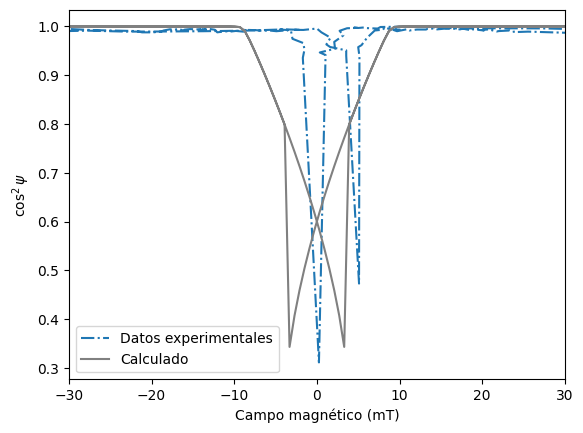

In [83]:
# Verificar resultados
def cargar_datos(temp):
    path = "K.txt"
    base_dir = "Datos/RvsHvsT_SECTOR2/EA/"
    archivo = base_dir + str(temp) + path
    df = pd.read_csv(archivo, encoding="latin-1")
    # print(df.columns)
    r_perp, dr = parametros(temp)  # Obtener r_perp y dr usando la función anterior
    Rxx = df["Rxx (ohm)"]
    cos_psi_2 = (Rxx - r_perp) / dr
    x = cos_psi_2 - (max(cos_psi_2) - 1)
    campo = df["Magnetic Field (T)"].to_numpy() * 1000  # Convertir a militeslas
    phi_M = df["angle (°)"]
    return x, campo

def magnetizacion_angulo(H_max,phi_H,temp):
    # Constantes
    K_u = R_u_dict[temp]
    K_c = R_c_dict[temp]
    phi_u = 0

    # Campo magnético y otros ángulos
    phi_H = np.radians(phi_H)  # Convertir a radianes
    H_vals = H_max * (np.linspace(0, 1, 500))  # Valores de H
    H_vals2= H_max * (np.linspace(1, -1, 500))  # Valores de H
    H_vals3= H_max * (np.linspace(-1, 1, 500))  # Valores de H

    # Función de energía
    def energia(phi_M, H):
        return  - H * np.cos(phi_M - phi_H) - (K_c / 4) * np.sin(2 * phi_M)**2 - K_u * np.cos(phi_M - phi_u)**2

    # Para almacenar la magnetización en función de H
    phi_M_vals = [0]
    # Minimizar la energía para cada valor de H
    for H in H_vals:
        res = minimize(energia, x0=phi_M_vals[-1], args=(H))  # Minimiza en el rango [-pi, pi]
        phi_M_vals.append(res.x[0])  # Guarda el ángulo que minimiza la energía
    phi_M_vals2 =  [phi_M_vals[-1]]
    for H in H_vals2:
      res = minimize(energia, x0=phi_M_vals2[-1], args=(H))
      phi_M_vals2.append(res.x[0])
    phi_M_vals3 =  [phi_M_vals2[-1]]
    for H in H_vals3:
      res = minimize(energia, x0=phi_M_vals3[-1], args=(H))
      phi_M_vals3.append(res.x[0])

    # Convertir lista de ángulos a arrays
    phi_M_vals = np.array(phi_M_vals)
    phi_M_vals2 = np.array(phi_M_vals2)
    phi_M_vals3 = np.array(phi_M_vals3)
    phi_M_vals=np.concatenate((phi_M_vals2[1:],phi_M_vals3[1:]))
    H_vals_all=np.concatenate((H_vals2,H_vals3))
    cos_psi2=np.cos(phi_M_vals)**2
    return cos_psi2,H_vals_all
temp=100
exp,H_exp=cargar_datos(temp)
teo,H_teo=magnetizacion_angulo(150,np.radians(0.0),temp)
plt.plot(H_exp, exp, "-.", markersize=2, label="Datos experimentales")
plt.plot(H_teo,teo,color="gray",label="Calculado")
plt.legend()
plt.ylabel(r"$\cos^2\psi$")
plt.xlabel("Campo magnético (mT)")
plt.xlim((-30,30))
plt.show()

## Método 2
Otra forma de calcular los parámetros de anisotropía magnetocristalina, $K_c$, y de anisotropía uniaxial, $K_u$ es minimizar la diferencia cuadrática entre el valor calculado de $\cos^2(\psi)$ y el valor experimental. Para ellos se seguiran los siguientes pasos:
- Se crea la función de la energía libre $F(H,\psi,R_u,R_c)$ y mediante la minimización de la energía se obtienen los valores de equilibrio de $\psi$.
- Se contruye una función $g(H,R_u,R_c)$ que nos de el valor $\cos^2\psi(H)$.
- Se contruye la función $Error(H,R_u,R_c)=(g(H,R_u,R_c)-cos^2\psi(H))^2$
- Para simplificar el cálculo se despreciará el valor de K_u

R_c óptimo: 50.0
R_u óptimo: 25.0
Error final: 796.8395183579273


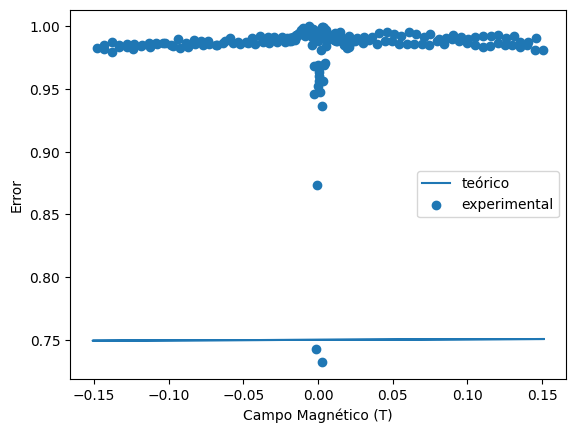

np.float64(796.8395183579273)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
temp=200
# Función para convertir los valores a numéricos
def is_numeric(series):
    return pd.to_numeric(series, errors='coerce')

# Función Rxx en función de psi
def rxx_func(psi, r_p, dr):
    psi = np.radians(psi)
    return r_p + dr * np.cos(psi)**2

# Función para obtener los parámetros r_perp y dr
def parametros(temp):
    path = "K_300mT_angular.txt"
    base_dir = "Datos/RvsH_angle_vsT_SECTOR1/"
    archivo = base_dir + str(temp) + path
    df = pd.read_csv(archivo, encoding="latin-1")
    df_numeric = df.apply(is_numeric)  # Aplicar la función columna por columna
    df = df_numeric.dropna()  # Eliminar filas con NaN
    Rxx = df["Rxx (ohm)"].to_numpy()
    angle = df["angle (°)"]
    initial_guess = [1, 1]  # Adivinanza inicial para los parámetros
    params, _ = curve_fit(rxx_func, angle, Rxx, p0=initial_guess)
    r_perp, dr = params
    return r_perp, dr

# Función para calcular cos(psi)^2 basado en Rxx y los parámetros ajustados
def cos_psi2(temp):
    path = "K.txt"
    base_dir = "Datos/RvsHvsT_SECTOR2/EA/"
    archivo = base_dir + str(temp) + path
    df = pd.read_csv(archivo, encoding="latin-1")
    df_numeric = df.apply(is_numeric)  # Aplicar la función columna por columna
    df = df_numeric.dropna()  # Eliminar filas con NaN
    Rxx = df["Rxx (ohm)"].to_numpy()
    r_perp, dr = parametros(temp)
    cos_psi_2 = (Rxx - r_perp) / dr
    x = cos_psi_2 - (max(cos_psi_2) - 1)
    H = df["Magnetic Field (T)"].to_numpy()  # Asegurarse de que sea array
    return x, H

# Función de error y minimización de la energía
def magnetizacion_angulo(H_max,R_c,R_u):


    # Campo magnético y otros ángulos
    phi_H = np.radians(8)  # Convertir a radianes
    H_vals = H_max * (np.linspace(0, 1, 100))  # Valores de H
    H_vals2= H_max * (np.linspace(1, -1, 100))  # Valores de H
    H_vals3= H_max * (np.linspace(-1, 1, 100))  # Valores de H

    # Función de energía
    def energia(psi, H, R_c, R_u):
        return -H * np.cos(psi - phi_H) - (R_c / 4) * np.sin(2 * psi)**2 - R_u * np.cos(psi)**2

    # Para almacenar la magnetización en función de H
    psi_vals = [0]

    # Minimizar la energía para cada valor de H
    for H in H_vals:
        res = minimize(energia, x0=psi_vals[-1], args=(H,R_c,R_u))  # Minimiza en el rango [-pi, pi]
        psi_vals.append(res.x[0])  # Guarda el ángulo que minimiza la energía
    psi_vals2 =  [psi_vals[-1]]
    for H in H_vals2:
      res = minimize(energia, x0=psi_vals2[-1], args=(H, R_c,R_u))
      psi_vals2.append(res.x[0])
    psi_vals3 =  [psi_vals2[-1]]
    for H in H_vals3:
      res = minimize(energia, x0=psi_vals3[-1], args=(H, R_c,R_u))
      psi_vals3.append(res.x[0])

    # Convertir lista de ángulos a arrays
    psi_vals = np.array(psi_vals)
    psi_vals2 = np.array(psi_vals2)
    psi_vals3 = np.array(psi_vals3)
    psi_vals=np.concatenate((psi_vals2[1:],psi_vals3[1:]))
    H_vals_all=np.concatenate((H_vals2,H_vals3))
    return psi_vals,H_vals_all


def F_error(params, H,plot="no"):
    R_c, R_u = params  # Desempacar los parámetros
    phi_H = np.radians(8)  # Ángulo dado
    angulo,x0_1=magnetizacion_angulo(max(H),R_c,R_u)
    y0_1=np.cos(angulo)**2
    g = interp1d(x0_1,y0_1,kind="linear")
    # Valor teórico basado en el ángulo psi
    teorico = g(H)

    # Interpolación experimental
    y0, x0 = cos_psi2(temp)  # Se asume que temp = 80
    f = interp1d(x0, y0, kind="linear")
    experimental = f(H)  # Interpolación para el valor de H
    if plot=="si":
        plt.plot(x0_1,y0_1,label="teórico")
        plt.scatter(x0,y0,label="experimental")
        plt.xlabel("Campo Magnético (T)")
        plt.ylabel("Error")
        plt.legend()
        plt.show()
    # Error cuadrático entre experimental y teórico
    error = (experimental - teorico)**2
    return np.sum(error)**2  # Devolver la suma de los errores cuadráticos

# Obtener cos(psi)^2 y el campo magnético H para temp = 80
x, H = cos_psi2(temp)
H=np.linspace(min(H),max(H),500)
# Minimización de F_error respecto a los parámetros R_c y R_u
res = minimize(F_error, x0=(50, 25), args=(H))

# Imprimir los valores óptimos de R_c y R_u
print("R_c óptimo:", res.x[0])
print("R_u óptimo:", res.x[1])

# Verificar el valor de F_error con los parámetros óptimos
error_final = F_error(res.x, H)
print("Error final:", error_final)


In [17]:
print(max(H))

0.15095
